In [11]:
!pip install kikuchipy
!pip install import_ipynb

import import_ipynb
import re
import torch 
import torch.utils.data as tor_utils
import os
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import time
import math
import impAt as at
import orix
from orix.quaternion import Rotation, Symmetry
from fastai.losses import BaseLoss
import kikuchipy as kp
import torch.nn.functional as F
from fastai.vision.all import *
from orix import sampling, plot, io
from orix.vector import Vector3d
from torch.utils.tensorboard import SummaryWriter

In [12]:
#Set the initial electron microscope energy value to 20kV
energy = 20

#Load in a nickel EBSD  master pattern with specified parameters
mp = kp.data.nickel_ebsd_master_pattern_small(projection="lambert", energy = energy)

#Get the point group symmetry of the master pattern
sym = mp.phase.point_group

#Set the size of the image to be generated
imgSize = 60

#Initialise an EBSD detector with specific settings
detector = kp.detectors.EBSDDetector(shape = (imgSize, imgSize), sample_tilt = 70, pc = [0.421, 0.7794, 0.5049], convention = "edax")

#Define a batch size for training
batchSize = 320

#Initialise an object using the previously obtained symmetry information to return symmetrical labels
breakdown = at.SymQuatBreakdown(sym)

In [13]:
#Get the phase information from the master pattern
ni = mp.phase

#Generate sample rotations using a specified method and resolution
sampleRot = sampling.get_sample_fundamental(method="cubochoric", resolution = 1, point_group=ni.point_group)

#Determine the number of training samples
numTrain = sampleRot.shape[0]

#Create a tensor for labels initialized with zeros
labels = torch.zeros((numTrain, 96, 4))

#Loop through each training sample and generate its labels
for i in range(numTrain):
    labels[i, :, :] = breakdown.breakdown(sampleRot.data[i, :])

#Generate simulated EBSD patterns for training data
sim = mp.get_patterns(rotations = sampleRot, detector = detector, energy = energy, dtype_out = np.float32, compute = True)

#Convert the simulated patterns to a torch tensor
imgs = torch.tensor(sim.data).unsqueeze(1)

#Sett the number of validation samples
num = 100000

#Generate random grain rotations for validation
grains = np.deg2rad(np.random.rand(num, 3) * 720 - 360)
valSampleRot = Rotation.from_euler(grains)

#Determine the number of validation samples
numVal = valSampleRot.shape[0]

#Create a tensor for validation labels initialized with zeros
valLabels = torch.zeros((numVal, 96, 4))

#Loop through each validation sample and generate its labels
for i in range(numVal):
    valLabels[i, :, :] = breakdown.breakdown(valSampleRot.data[i, :])

#Generate simulated EBSD patterns for validation data
valSim = mp.get_patterns(rotations=valSampleRot, detector=detector, energy=energy, dtype_out=np.float32, compute=True)

#Convert the simulated validation patterns to a torch tensor
valImgs = torch.tensor(valSim.data).unsqueeze(1)

[########################################] | 100% Completed | 30.58 s
[########################################] | 100% Completed | 5.57 ss


In [14]:
#Initialise a transformation to set NaN values to zero
nanFilter = at.setNaNToZero()

#Set parameters for color jittering
brightness = 0.4
contrast = brightness
saturation = brightness
hue = brightness / 2

#Initialise various image augmentation transformations using standard torchvision transforms
sharp = transforms.RandomAdjustSharpness(2, p=0.5)
autocontrast = transforms.RandomAutocontrast(p=0.5)
equalise = transforms.RandomEqualize(p=0.5)
augMix = transforms.AugMix(5, all_ops=False)

jitter = transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)
valJitter = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2)

erase = transforms.RandomErasing()

#Define lists of transformations for training and validation, using above transforms
trainTransformList = [jitter, sharp, autocontrast, equalise]
valTransformList = [jitter, sharp, autocontrast, equalise]

#Define a wapper function to apply random transformations with probability p
def randomTransform(transform, p=0.5):
    return transforms.RandomApply([transform], p=p)

#Apply a random chance of activation to the list of transforms
trainTransformList = [randomTransform(i) for i in trainTransformList]

#Consolidate standard torchvision transforms to a single transform 
trainTransform = at.mixedTransform(trainTransformList)
valTransform = at.mixedTransform(valTransformList)

#Initialise noise and brightness related transformations for training and validation
trainNoise = at.AddNoise(0.2)
valNoise = at.AddNoise(0.1)

trainBright = at.Bright(5)
valBright = at.Bright(1)

trainBrightNoise = at.BrightNoise(0.25)
valBrightNoise = at.BrightNoise(0.1)

#Initialise a random blur transformation
randBlur = at.randomBlur(3)

#Initialise normalisation transformation
Norm = at.Normalise()

#Initialise circular crop transformations
CircCrop = at.RandCircularCrop(radius=20)
StdCrop = at.CircularCrop()

#Initialise add and scale transformations
add = at.addTo()
scale = at.scaleBy()

#Initialise zoom and stetch transformations
stretcher = at.StretchAndCropTransform(1.3, 1.3, 60)
zoomTmf = at.zoom(1.3, 60)

#Create a list of transformations for training data with random application
tmfs = [Norm, trainTransform, randBlur, Norm, trainBright, trainBrightNoise, trainNoise, Norm, CircCrop, add, scale, nanFilter]
tmfs = [randomTransform(i, 0.75) for i in tmfs]

#Remove random chance from the nanFilter
tmfs[-1] = nanFilter

#Create a list of transformations for validation data
valTmfs = [Norm, valTransform, randBlur, Norm, valBright, valBrightNoise, valNoise, Norm, StdCrop, nanFilter]

torch.Size([60, 60])
tensor(0.9187)
tensor(0.0572)


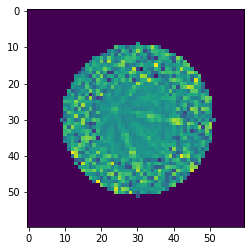

torch.Size([60, 60])
tensor(1.6343)
tensor(-0.0956)


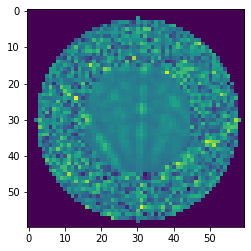

torch.Size([60, 60])
tensor(1.6755)
tensor(0.)


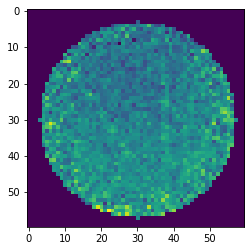

torch.Size([60, 60])
tensor(1.6514)
tensor(0.)


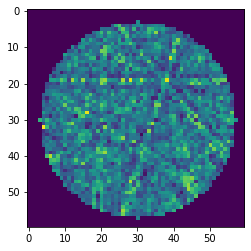

torch.Size([60, 60])
tensor(0.6027)
tensor(0.1025)


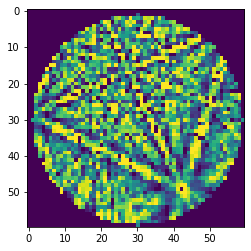

torch.Size([60, 60])
tensor(1.4664)
tensor(-0.4301)


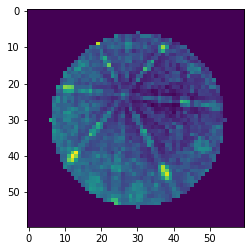

torch.Size([60, 60])
tensor(1.6023)
tensor(-0.2701)


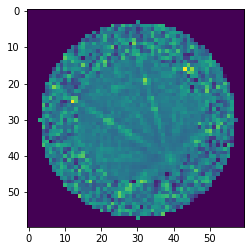

torch.Size([60, 60])
tensor(1.2324)
tensor(-0.2346)


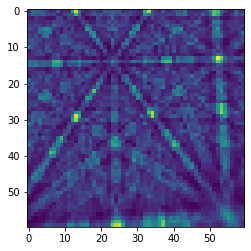

torch.Size([60, 60])
tensor(0.8265)
tensor(-0.1068)


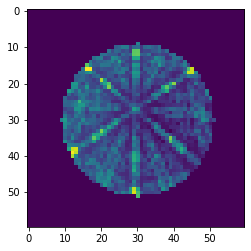

torch.Size([60, 60])
tensor(1.6653)
tensor(0.)


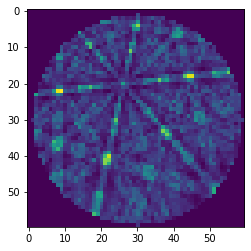

torch.Size([60, 60])
tensor(1.4377)
tensor(0.0210)


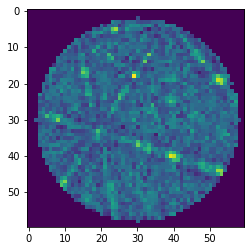

torch.Size([60, 60])
tensor(1.0237)
tensor(-0.2086)


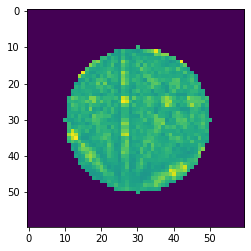

torch.Size([60, 60])
tensor(1.3227)
tensor(0.)


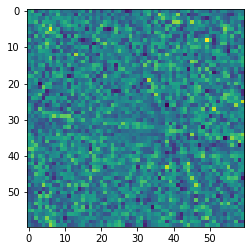

torch.Size([60, 60])
tensor(1.0018)
tensor(0.0018)


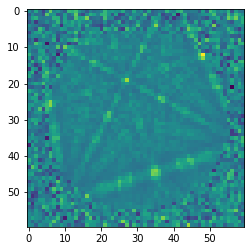

torch.Size([60, 60])
tensor(1.4236)
tensor(0.)


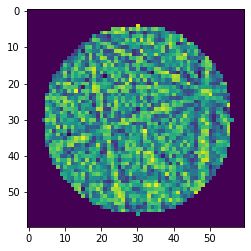

torch.Size([60, 60])
tensor(1.1929)
tensor(0.1929)


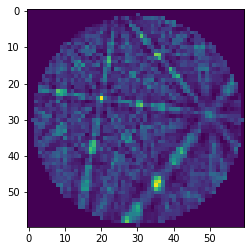

torch.Size([60, 60])
tensor(1.4525)
tensor(0.1211)


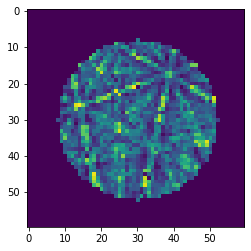

torch.Size([60, 60])
tensor(5.0206)
tensor(2.1882)


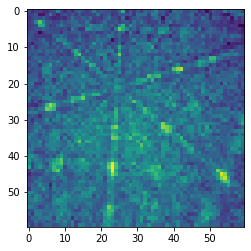

torch.Size([60, 60])
tensor(1.9853)
tensor(0.1495)


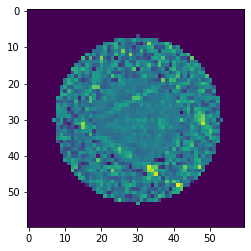

torch.Size([60, 60])
tensor(0.9474)
tensor(-0.1588)


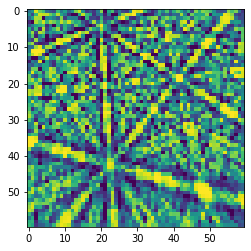

In [15]:
#Create a training and validation dataset using the simulated data
data = at.greyDataset(imgs, labels, tmfs)
valData = at.greyDataset(valImgs, valLabels, valTmfs)

#Create torch data loader for training and validation data
dls = DataLoader(data, batch_size = batchSize, shuffle = True, num_workers=12)
valDls = DataLoader(valData, batch_size = batchSize, shuffle = True, num_workers=12)

#Get a single batch of data from the data loader
dlsIter = iter(dls)
data, labels = next(dlsIter)
dlsIter = None

#Loop through the first 20 images in the batch
for i in range(20):
    #Extract the image data to CPU
    img = data[i, 0, :, :].cpu()
    
    #Print the shape of the image tensor
    print(img.shape)
    
    #Print the maximum and minimum pixel values in the image tensor
    print(torch.max(img))
    print(torch.min(img))
    
    #Display the image
    plt.imshow(img)
    plt.show()

In [25]:
#Set device to cuda if a gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Initialise a custom resnet50 architecture and move it to the device
model = at.DeepGreyResnet50(4, 0, 0)
model = model.to(device)

#Define metric and criterion
metric = at.trueRotDistance
criterion = at.l1Simple


#Define gradient clip amount
clip_value = 1.0

#Define number of training epochs
epochs = 10

#Define number of batches before updating weights
accum_size = 5

#Defining optimiser
optimiser = optim.Adam(model.parameters(), lr = 0.01)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr = 1e-3, steps_per_epoch=int(len(dls) / accum_size) + 1, epochs=epochs)

In [26]:
#tensorboard --logdir . --bind_all

#Define the path where the run data will be store
path = 'runs/ni3'

#Create a SummaryWriter object for TensorBoard, specifying the directory to store data
writer = SummaryWriter(path)

#Set initial values for training
offset = 0
i = 0
current_loss = 0.0

In [ ]:
#Loop through the number of epochs specified for training
for epoch in range(epochs):
    
    #Reset all running counts to 0 and start timing
    start_time = time.time()
    running_loss = 0.0
    val_running_loss = 0.0
    metric_running_loss = 0.0
    nan_count = 0

    #Set model to train
    model.train() 
    
    #Loop through the batches in the training data loader
    for inputs, labels in dls:
        #Move data to the device
        inputs, labels = inputs.to(device), labels.to(device)
        
        #Model forwards pass
        outputs = model(inputs)
        
        #Calculate loss
        loss = criterion(outputs, labels)
        
        #Computing gradients using backwards propagation
        loss.backward()

        #Clip gradients to a specified maximum
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        #Increment running losses and counts
        running_loss += loss.item()
        current_loss += loss.item()
        i += 1

        #Every 30 batches log the running loss to tensorboard
        if i % 30 == 0:    
            writer.add_scalar('training loss', current_loss / 30, i + offset)
            current_loss = 0.0
        
        #Use gradient accumulation to update the weights after several batches 
        if i % accum_size == 0:
            for param in model.parameters():
                if param.grad is not None:
                    param.grad.data *= 1 / accum_size
            
            optimiser.step()
            scheduler.step()
            optimiser.zero_grad()

    #Set model to evaluate
    model.eval() 
    
    #Loop through the batches in the validation data loader
    for inputs, labels in valDls:
        #Move data to the device
        inputs, labels = inputs.to(device), labels.to(device)
        
        #Model forwards pass
        outputs = model(inputs)
        
        #Calculate loss
        val_loss = criterion(outputs, labels)
        
        #Calculate metric
        metric_loss = metric(outputs,labels)

        #Increment running losses
        metric_running_loss += metric_loss.item()
        val_running_loss += val_loss.item()

        #Calculate time taken for epoch
        end_time = time.time()
        epoch_time = end_time - start_time

    #Print losses and metrics for the epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(dls):.4f}, Validation Loss: {val_running_loss / len(valDls) :.4f}, Metric Loss: {metric_running_loss / len(valDls) :.4f},  Time: {epoch_time:.2f} seconds")
        
    #torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),
    #    'loss': loss,},"go_v1_" + str(epoch))
    
print("Training finished!")

Epoch 1/10, Loss: 0.0666, Validation Loss: 0.0230, Metric Loss: 4.9114,  Time: 222.30 seconds


In [ ]:
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,},
        "torched")